# Project 1: Microsoft Goes to the Movies

##### Authors: Muoyo Okome & Chuck Pryor

##### Date: December 4, 2019

## Introduction

Microsoft has decided to create a **new movie studio** and enter the movie business. Our analysis below explores current trends at the box office in order to help CEO Satya Nadella and his executive team decide how best to move forward with this exciting new venture.

## Getting Started

First, let's import all of the packages we'll need for our analysis.

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
%matplotlib inline

## The Datasets

In the cell below we explore which datasets we have available in our data directory

In [65]:
ls -lath ./data/*

-rw-r--r--  1 DAILYSPARK  staff    12M Dec  2 11:09 ./data/imdb.title.principals.csv.gz
-rw-r--r--  1 DAILYSPARK  staff    52K Dec  2 11:09 ./data/bom.movie_gross.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   150K Dec  2 11:09 ./data/tn.movie_budgets.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   487K Dec  2 11:09 ./data/rt.movie_info.tsv.gz
-rw-r--r--  1 DAILYSPARK  staff   3.3M Dec  2 11:09 ./data/imdb.title.basics.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   3.2M Dec  2 11:09 ./data/rt.reviews.tsv.gz
-rw-r--r--  1 DAILYSPARK  staff    17M Dec  2 11:09 ./data/imdb.name.basics.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   527K Dec  2 11:09 ./data/imdb.title.ratings.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   5.3M Dec  2 11:09 ./data/imdb.title.akas.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   808K Dec  2 11:09 ./data/tmdb.movies.csv.gz
-rw-r--r--  1 DAILYSPARK  staff   1.8M Dec  2 11:09 ./data/imdb.title.crew.csv.gz






Then we read in all datasets using Pandas.





In [2]:
# read movie CSV & TSV files. Use latin1 encoding for 'rt.reviews.tsv.gz' to avoid errors
bom_movie_gross_df = pd.read_csv('./data/bom.movie_gross.csv.gz')
tn_budgets_df = pd.read_csv('./data/tn.movie_budgets.csv.gz')
rt_reviews_df = pd.read_csv('./data/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
rt_movie_info_df = pd.read_csv('./data/rt.movie_info.tsv.gz', sep='\t')
imdb_ratings_df = pd.read_csv('./data/imdb.title.ratings.csv.gz')
imdb_crew_df = pd.read_csv('./data/imdb.title.crew.csv.gz')
imdb_title_basics_df = pd.read_csv('./data/imdb.title.basics.csv.gz')
imdb_akas_df = pd.read_csv('./data/imdb.title.akas.csv.gz')
imdb_principals_df = pd.read_csv('./data/imdb.title.principals.csv.gz')
imdb_name_basics_df = pd.read_csv('./data/imdb.name.basics.csv.gz')
tmdb_movies_df = pd.read_csv('./data/tmdb.movies.csv.gz')


Initial probes using functions like **info()**, **head()**, and **describe()** allow us to see what kind of data we have available. Though helpful to us, since it's not that interesting, I'll spare you the details and move most of this out of view.

In [10]:
# tn_budgets_df contains similar info to bom_movie_gross_df, but all records are non-null. 5782 rows
tn_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
id                   5782 non-null int64
release_date         5782 non-null object
movie                5782 non-null object
production_budget    5782 non-null object
domestic_gross       5782 non-null object
worldwide_gross      5782 non-null object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


## Production Budgets vs. Gross Revenues

We decided to use the movie budgets data from **The-Numbers.com** since it gives us information on production budgets as well as domestic and worldwide gross revenues for over 5000 movies and the data appears to be relatively complete.

In order to start our calculations we needed to convert the budget and revenue columns from strings to numbers and also convert the release date column to datetime objects. We also chose to limit the date range to years between 2010-2018 in order to be congruent with the other data sets we have access to.

In [3]:
# change production_budget, domestic_gross, worldwide_gross from strings to numbers
tn_budgets_df['production_budget'] = tn_budgets_df['production_budget'].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
tn_budgets_df['domestic_gross'] = tn_budgets_df['domestic_gross'].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)
tn_budgets_df['worldwide_gross'] = tn_budgets_df['worldwide_gross'].apply(lambda x: x.replace('$', '').replace(',', '')).astype(float)


In [4]:
# convert release_date to datetime object
tn_budgets_df['release_date'] = pd.to_datetime(tn_budgets_df['release_date'])

In [5]:
# limit tn_budgets_df to 2010-2018 like other data sets - 2124 records
tn_budgets_2010_2018_df = tn_budgets_df[tn_budgets_df['release_date'].apply(lambda x: x.year >= 2010 and x.year <= 2018)]

In [7]:
tn_budgets_2010_2018_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 1 to 5780
Data columns (total 6 columns):
id                   2124 non-null int64
release_date         2124 non-null datetime64[ns]
movie                2124 non-null object
production_budget    2124 non-null float64
domestic_gross       2124 non-null float64
worldwide_gross      2124 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 116.2+ KB


Viewing our dataset sorted by worldwide gross revenues, from greatest to least, things appear to be making sense. We are on the right track.

In [69]:
tn_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
42,43,1997-12-19,Titanic,200000000.0,659363944.0,2.208208e+09
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09
33,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09
66,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09
26,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
41,42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09
260,61,2011-07-15,Harry Potter and the Deathly Hallows: Part II,125000000.0,381193157.0,1.341693e+09


Let's draw a few scatterplots to get a better idea on the relationship between production budget and gross revenues, both domestic and worldwide.

In [75]:
sns.set(color_codes=True)

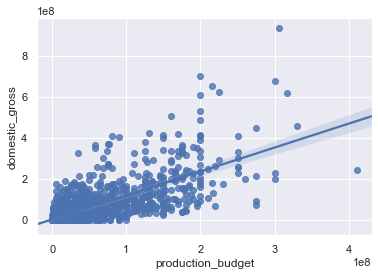

In [74]:
sns.regplot(x='production_budget', y='domestic_gross', data=tn_budgets_2010_2018_df);

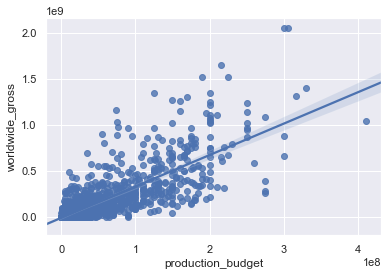

In [73]:
sns.regplot(x='production_budget', y='worldwide_gross', data=tn_budgets_2010_2018_df);

## The Impact of Genre

Now, we join the budget data we've been using with the title basics dataset from IMDB in order to learn the genre or genres each movie falls into, so that we can investigate which genres might be best for our goals.

In [9]:
# Join tn_budgets_df to imdb_title_basics_df to gain genre information
joined_df = tn_budgets_2010_2018_df.join(imdb_title_basics_df.set_index('primary_title'), on='movie', how='inner')

In [10]:
joined_df = joined_df.sort_values('worldwide_gross', ascending=False)

In [13]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2535 entries, 6 to 5780
Data columns (total 11 columns):
id                   2535 non-null int64
release_date         2535 non-null datetime64[ns]
movie                2535 non-null object
production_budget    2535 non-null float64
domestic_gross       2535 non-null float64
worldwide_gross      2535 non-null float64
tconst               2535 non-null object
original_title       2535 non-null object
start_year           2535 non-null int64
runtime_minutes      2337 non-null float64
genres               2502 non-null object
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 237.7+ KB


In [12]:
# Observe most common genres among the highest grossing films
joined_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"
33,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi"
66,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,tt2820852,Furious Seven,2015,137.0,"Action,Crime,Thriller"
26,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,tt0848228,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi"
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi"
41,42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09,tt1825683,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi"
112,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,tt4881806,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt1323045,Frozen,2010,93.0,"Adventure,Drama,Sport"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt1611845,Wai nei chung ching,2010,92.0,"Fantasy,Romance"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt2294629,Frozen,2013,102.0,"Adventure,Animation,Comedy"


In [14]:
# Group our joined_df by genres and sum to get an idea of the highest grossing categories
joined_df.groupby('genres').sum()

,id,production_budget,domestic_gross,worldwide_gross,start_year,runtime_minutes
genres,,,,,,
Action,1227,5.845500e+08,4.088809e+08,1.236312e+09,44306,795.0
"Action,Adventure",82,1.850000e+07,1.177400e+04,1.136600e+07,4024,220.0
"Action,Adventure,Animation",689,1.820000e+09,2.473161e+09,6.793873e+09,30202,1501.0
"Action,Adventure,Biography",120,3.350000e+08,2.835859e+08,9.018259e+08,8063,495.0
"Action,Adventure,Comedy",1173,2.253500e+09,3.191676e+09,8.838180e+09,50373,2710.0
...,...,...,...,...,...,...
Sci-Fi,238,1.583700e+08,4.125634e+08,8.211419e+08,10069,292.0
"Sci-Fi,Thriller",56,2.000000e+04,0.000000e+00,0.000000e+00,2011,78.0
Sport,49,1.900000e+07,5.310554e+06,5.745503e+06,2014,114.0


## The Cream Rises: Insights from the Top 200 Grossing Movies

For the remainder of our analysis, we chose to focus on the 200 movies in our joined dataset with the highest gross revenues worldwide, representing the top 8% of movies during the 2010-2018 period we are analyzing. This enables us to make some observations about characteristics these top grossing movies share that may be advantageous to our cause.

When we view the top 200 grossing movies in descending order, some patterns begin to emerge in the genre column. Our dataset includes up to three genres for each movie, and we chose to keep that level of data because of the descriptiveness it provides. Despite the number of possible permutations, certain patterns still emerge. See below.

**Simply browsing through, Action/Adventure seems to make quite a few appearances at the top.** But that is no place to stop. Let's go deeper!

In [142]:
# Put top 200 worldwide grossing movies from 2010-2018 into their own dataframe
top200_df = joined_df.head(200)
top200_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,genres
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi"
33,34,2015-06-12,Jurassic World,215000000.0,652270625.0,1.648855e+09,tt0369610,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi"
66,67,2015-04-03,Furious 7,190000000.0,353007020.0,1.518723e+09,tt2820852,Furious Seven,2015,137.0,"Action,Crime,Thriller"
26,27,2012-05-04,The Avengers,225000000.0,623279547.0,1.517936e+09,tt0848228,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi"
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09,tt2395427,Avengers: Age of Ultron,2015,141.0,"Action,Adventure,Sci-Fi"
41,42,2018-02-16,Black Panther,200000000.0,700059566.0,1.348258e+09,tt1825683,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi"
112,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000.0,417719760.0,1.305773e+09,tt4881806,Jurassic World: Fallen Kingdom,2018,128.0,"Action,Adventure,Sci-Fi"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt1323045,Frozen,2010,93.0,"Adventure,Drama,Sport"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt1611845,Wai nei chung ching,2010,92.0,"Fantasy,Romance"
155,56,2013-11-22,Frozen,150000000.0,400738009.0,1.272470e+09,tt2294629,Frozen,2013,102.0,"Adventure,Animation,Comedy"


We can use bar plots to visualize what's going on more clearly. First let's see the genre combinations among the top 200 movies that grossed the most revenue. 

When you take a holistic view, **movies including Action & Adventure in their genre classification tended to do the best overall.**

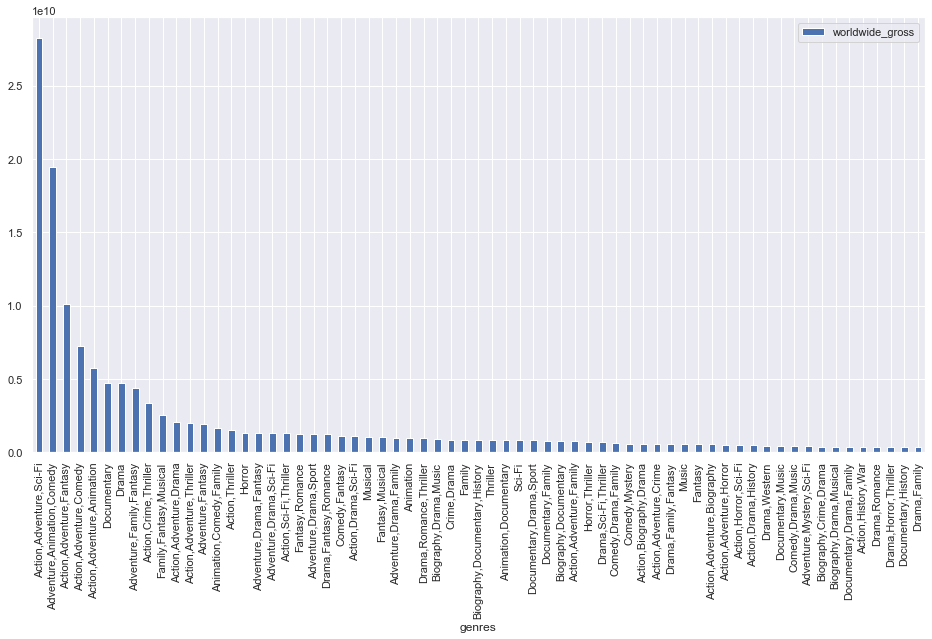

In [12]:
# Show total grossed per genre among the top 200 grossing worldwide from 2010-2018
top200_df.groupby('genres').sum().sort_values(by='worldwide_gross', 
                                             ascending=False).plot(kind='bar', y='worldwide_gross', figsize=(16,8));

But perhaps this is not the best way of looking at things since there is potential for outliers to skew our results. To avoid this, we can instead focus on the count of movies per genre. 

Among the top 200 grossing movies, which genre combinations made the most appearances in our data?

**Remaining consistent with our previous findings, Action/Adventure continues to dominate.**

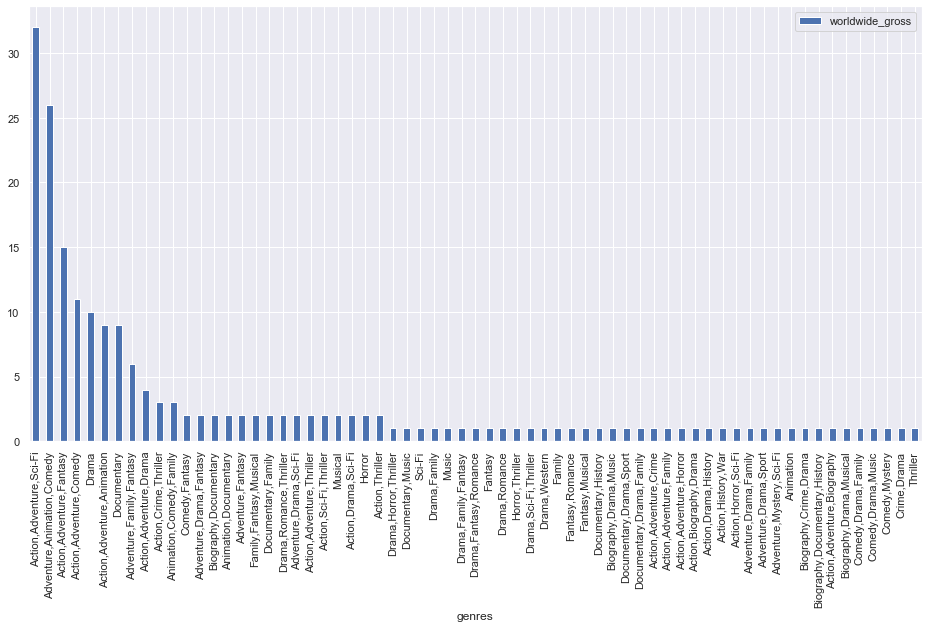

In [144]:
# Show total count per genre among the top 200 grossing worldwide from 2010-2018
top200_df.groupby('genres').count().sort_values(by='worldwide_gross', 
                                             ascending=False).plot(kind='bar', y='worldwide_gross', figsize=(16,8));


## Guns for Hire: Which Actors & Directors Should We Pursue?

Now that we know how much to budget for our movie and which genre we should focus on, the personnel question remains. Are there certain key women or men we should look to bring in to maximize our chances of a top grossing film? Let's explore.

We joined our existing database with 2 more from IMDB, principals & name basics, which allowed us to know the names of actors & directors working on each top 200 grossing movie. If certain names are appearing more than others, perhaps these are people we should consider for our project.

In [115]:
ultimate_df = top200_df.join(imdb_principals_df.set_index('tconst'), on='tconst', how='left').join(
                             imdb_name_basics_df.set_index('nconst'), on='nconst', how='left')

In [116]:
ultimate_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,tconst,original_title,start_year,runtime_minutes,...,ordering,nconst,category,job,characters,primary_name,birth_year,death_year,primary_profession,known_for_titles
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,...,10.0,nm0456158,writer,based on the Marvel comics by,NaN,Jack Kirby,1917.0,1994.0,"writer,animation_department,miscellaneous","tt4154796,tt4154756,tt0371746,tt1825683"
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,...,1.0,nm0000375,actor,NaN,"[""Tony Stark"",""Iron Man""]",Robert Downey Jr.,1965.0,NaN,"actor,producer,soundtrack","tt0848228,tt1300854,tt0988045,tt0371746"
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,...,2.0,nm1165110,actor,NaN,"[""Thor""]",Chris Hemsworth,1983.0,NaN,"actor,soundtrack,producer","tt3501632,tt0800369,tt0848228,tt1735898"
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,...,3.0,nm0749263,actor,NaN,"[""Bruce Banner"",""Hulk""]",Mark Ruffalo,1967.0,NaN,"actor,producer,director","tt1100089,tt1895587,tt0848228,tt0842926"
6,7,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,tt4154756,Avengers: Infinity War,2018,149.0,...,4.0,nm0262635,actor,NaN,"[""Steve Rogers"",""Captain America""]",Chris Evans,1981.0,NaN,"actor,producer,director","tt1843866,tt0848228,tt0458339,tt3498820"


In [26]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1795 entries, 6 to 243
Data columns (total 21 columns):
id                    1795 non-null int64
release_date          1795 non-null datetime64[ns]
movie                 1795 non-null object
production_budget     1795 non-null float64
domestic_gross        1795 non-null float64
worldwide_gross       1795 non-null float64
tconst                1795 non-null object
original_title        1795 non-null object
start_year            1795 non-null int64
runtime_minutes       1760 non-null float64
genres                1783 non-null object
ordering              1793 non-null float64
nconst                1793 non-null object
category              1793 non-null object
job                   706 non-null object
characters            712 non-null object
primary_name          1793 non-null object
birth_year            1225 non-null float64
death_year            101 non-null float64
primary_profession    1771 non-null object
known_for_titles      17

In [117]:
ultimate_df['category'].value_counts()

actor                  481
writer                 481
actress                233
director               233
producer               203
composer                72
cinematographer         33
editor                  33
self                    17
production_designer      7
Name: category, dtype: int64

In [128]:
top_actors = ultimate_df.loc[
    (ultimate_df['category'] == 'actor') | (ultimate_df['category'] == 'actress')]['primary_name'].value_counts()

In [138]:
top_directors = ultimate_df.loc[ultimate_df['category'] == 'director']['primary_name'].value_counts()

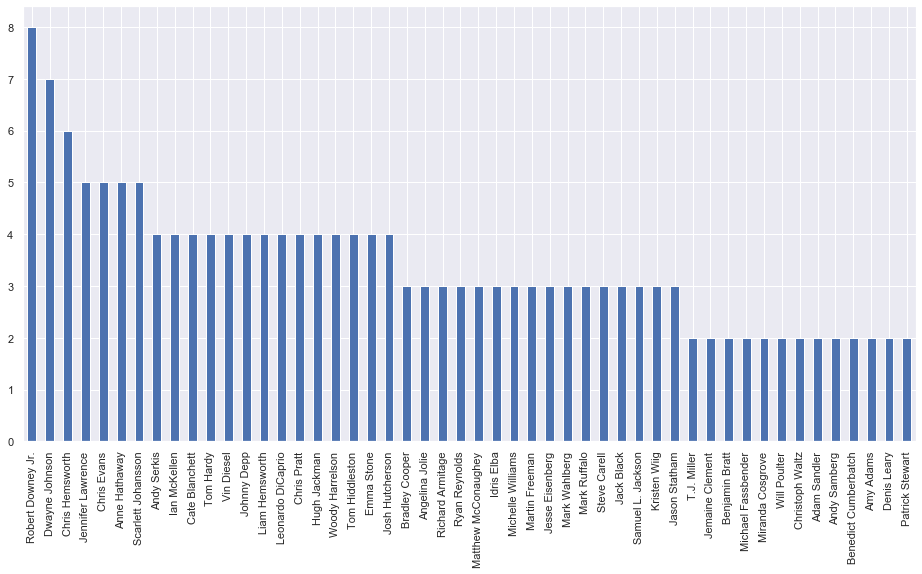

In [131]:
top_actors.head(50).plot(kind='bar', figsize=(16,8));

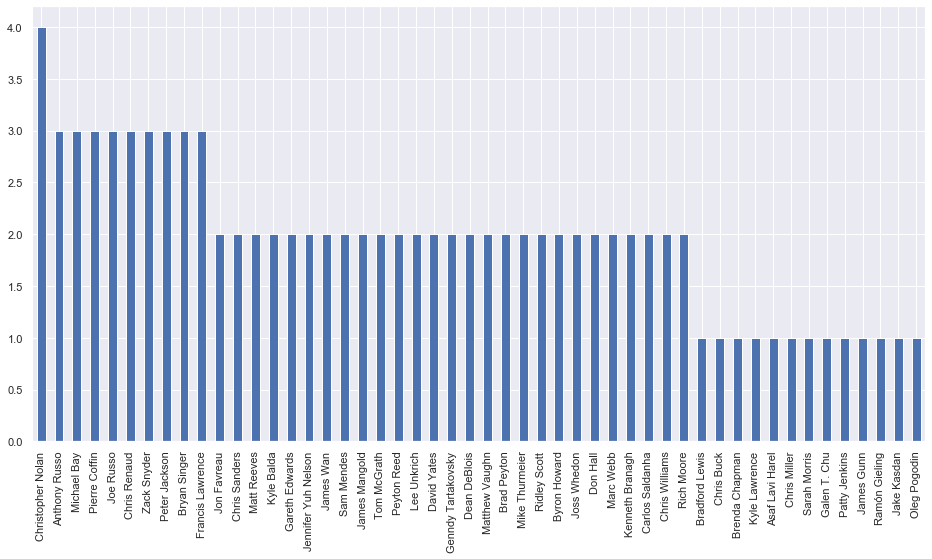

In [139]:
top_directors.head(50).plot(kind='bar', figsize=(16,8));

In [134]:
top_actors.head(50)

Robert Downey Jr.       8
Dwayne Johnson          7
Chris Hemsworth         6
Jennifer Lawrence       5
Chris Evans             5
Anne Hathaway           5
Scarlett Johansson      5
Andy Serkis             4
Ian McKellen            4
Cate Blanchett          4
Tom Hardy               4
Vin Diesel              4
Johnny Depp             4
Liam Hemsworth          4
Leonardo DiCaprio       4
Chris Pratt             4
Hugh Jackman            4
Woody Harrelson         4
Tom Hiddleston          4
Emma Stone              4
Josh Hutcherson         4
Bradley Cooper          3
Angelina Jolie          3
Richard Armitage        3
Ryan Reynolds           3
Matthew McConaughey     3
Idris Elba              3
Michelle Williams       3
Martin Freeman          3
Jesse Eisenberg         3
Mark Wahlberg           3
Mark Ruffalo            3
Steve Carell            3
Jack Black              3
Samuel L. Jackson       3
Kristen Wiig            3
Jason Statham           3
T.J. Miller             2
Jemaine Clem

In [140]:
top_directors.head(50)

Christopher Nolan      4
Anthony Russo          3
Michael Bay            3
Pierre Coffin          3
Joe Russo              3
Chris Renaud           3
Zack Snyder            3
Peter Jackson          3
Bryan Singer           3
Francis Lawrence       3
Jon Favreau            2
Chris Sanders          2
Matt Reeves            2
Kyle Balda             2
Gareth Edwards         2
Jennifer Yuh Nelson    2
James Wan              2
Sam Mendes             2
James Mangold          2
Tom McGrath            2
Peyton Reed            2
Lee Unkrich            2
David Yates            2
Genndy Tartakovsky     2
Dean DeBlois           2
Matthew Vaughn         2
Brad Peyton            2
Mike Thurmeier         2
Ridley Scott           2
Byron Howard           2
Joss Whedon            2
Don Hall               2
Marc Webb              2
Kenneth Branagh        2
Carlos Saldanha        2
Chris Williams         2
Rich Moore             2
Bradford Lewis         1
Chris Buck             1
Brenda Chapman         1


## Additional Notes

Below are the other data sets that we looked into, but did not rely on for our analysis in this case.

In [77]:
bom_movie_gross_df.sort_values('domestic_gross', ascending=False).head()

,title,studio,domestic_gross,foreign_gross,year
1872,Star Wars: The Force Awakens,BV,936700000.0,"1,131.6",2015
3080,Black Panther,BV,700100000.0,646900000,2018
3079,Avengers: Infinity War,BV,678800000.0,"1,369.5",2018
1873,Jurassic World,Uni.,652300000.0,"1,019.4",2015
727,Marvel's The Avengers,BV,623400000.0,895500000,2012


In [78]:
# 3387 records in bom_movie_gross_df. 1350 foreign gross records missing. 5 studio records missing
bom_movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
title             3387 non-null object
studio            3382 non-null object
domestic_gross    3359 non-null float64
foreign_gross     2037 non-null object
year              3387 non-null int64
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [67]:
# Attempted to sort rt_movie_info_df by box_office, but it's a string value
rt_movie_info_df.sort_values('box_office', ascending=False).head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
16,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,"Dec 20, 2013","Mar 18, 2014",$,"99,165,609",129 minutes,Sony Pictures
1510,1944,"In the 3D action-comedy The Green Hornet, Brit...",PG-13,Action and Adventure|Comedy|Science Fiction an...,Michel Gondry,Evan Goldberg|Seth Rogen,"Jan 14, 2011","May 3, 2011",$,"98,000,000",119 minutes,Sony Pictures
207,274,Natalie Portman stars in this western concerni...,R,Action and Adventure|Drama|Western,NaN,NaN,"Jan 29, 2016","Apr 26, 2016",$,"976,847",97 minutes,NaN
1469,1890,A misplaced sausage and his savory friends emb...,R,Animation|Comedy,Conrad Vernon|Greg Tiernan,Kyle Hunter|Ariel Shaffir|Seth Rogen|Evan Gold...,"Aug 12, 2016","Nov 8, 2016",$,"97,661,826",89 minutes,Sony Pictures
1323,1711,"Directed by Garry Marshall, The Princess Diari...",G,Comedy|Kids and Family,Garry Marshall,Shonda Rhimes,"Aug 11, 2004","Dec 14, 2004",$,"95,111,012",113 minutes,NaN


In [29]:
# 1560 rows... a lot of missing values for box_office, studio
rt_movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
id              1560 non-null int64
synopsis        1498 non-null object
rating          1557 non-null object
genre           1552 non-null object
director        1361 non-null object
writer          1111 non-null object
theater_date    1201 non-null object
dvd_date        1201 non-null object
currency        340 non-null object
box_office      340 non-null object
runtime         1530 non-null object
studio          494 non-null object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [69]:
rt_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [71]:
imdb_ratings_df.head()

,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [89]:
# Remove unneccesary index column 'Unnamed: 0'
tmdb_movies_df = tmdb_movies_df.drop(columns='Unnamed: 0')

In [91]:
# Perhaps the genre, popularity, vote_average, vote_count columns of tmdb_movies_df may be useful to us
tmdb_movies_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [90]:
# tmdb_movies_df contains 26517 records. All of them appear to be complete (allegedly)
tmdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 9 columns):
genre_ids            26517 non-null object
id                   26517 non-null int64
original_language    26517 non-null object
original_title       26517 non-null object
popularity           26517 non-null float64
release_date         26517 non-null object
title                26517 non-null object
vote_average         26517 non-null float64
vote_count           26517 non-null int64
dtypes: float64(2), int64(2), object(5)
memory usage: 1.8+ MB


In [74]:
# imdb_crew_df will be useful for telling us if a certain set of directors/writers will help our cause
imdb_crew_df.head()

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


In [83]:
# imdb_titles_df may be useful telling us which genres tend to succeed the most
imdb_title_basics_df.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [97]:
imdb_title_basics_df['genres'].value_counts().head(25)

Documentary                      32185
Drama                            21486
Comedy                            9177
Horror                            4372
Comedy,Drama                      3519
Thriller                          3046
Action                            2219
Biography,Documentary             2115
Drama,Romance                     2079
Comedy,Drama,Romance              1558
Documentary,Drama                 1554
Comedy,Romance                    1507
Romance                           1454
Documentary,Music                 1365
Drama,Thriller                    1335
Documentary,History               1289
Horror,Thriller                   1253
Biography,Documentary,History     1230
Biography,Documentary,Drama       1028
Family                             939
Animation                          828
Drama,Family                       784
Action,Crime,Drama                 727
Comedy,Horror                      724
Crime,Drama                        723
Name: genres, dtype: int6

In [84]:
imdb_title_basics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
tconst             146144 non-null object
primary_title      146144 non-null object
original_title     146123 non-null object
start_year         146144 non-null int64
runtime_minutes    114405 non-null float64
genres             140736 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [76]:
# We probably don't need imdb_akas for now
imdb_akas_df.head()

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


In [77]:
# imdb_principals_df may be useful for telling us if a certain set of directors/writers will help our cause
imdb_principals_df.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [78]:
# imdb_name_basics_df will allow us to pair the rest of our data with actual names
imdb_name_basics_df.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [79]:
# Used statsmodel/matpotlib in order to calculate a regression line for budget vs revenue. 
# Since that is not the focus of this project, moving to this section for now.

# Scatterplot for production_budget vs domestic_gross 
# ax = tn_budgets_2010_2018_df.plot(kind='scatter', x='production_budget', y='domestic_gross', color='orange', figsize=(10,10));

# ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
                                                                             
                                                                             
# regress "domestic_gross" onto "production_budget" (plus an intercept)
# model = sm.OLS(tn_budgets_2010_2018_df['production_budget'], sm.add_constant(tn_budgets_2010_2018_df['domestic_gross']))

# plot regression line
# abline_plot(model_results=model.fit(), ax=ax, color='darkorange')
                                                                             
                                                                             
                                                                             
# Scatterplot for production_budget vs worldwide_gross 
# ax = tn_budgets_2010_2018_df.plot(kind='scatter', x='production_budget', y='worldwide_gross', figsize=(10,10))
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
# ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


# regress "worldwide_gross" onto "production_budget" (plus an intercept)
# model = sm.OLS(tn_budgets_2010_2018_df['production_budget'], sm.add_constant(tn_budgets_2010_2018_df['worldwide_gross']))

# plot regression line
# abline_plot(model_results=model.fit(), ax=ax, color='darkblue')

# Now that we have the regression lines, how can we use them to predict gross revenues?